<h2>
Simulation with the same specifications as in the experiment described
</h2>

In [69]:
from classes import *

# How to use the framework for simulations
1. Set up an environment

    1.1 Create the environment itself

    1.2. Set the barrier for the environment

    1.3. Set the prospect spawner for the environment

    1.4. Spawn the individuals

    1.5. Create initial statistics
    
2. Run the simulation
3. Examine the results

##  1. Set up an environment

### 1.1. Create the environment itself

- The individuals start at position 2

- The initial and maximum population size is 500

- The spawn variation is 0.02, it determines with how much variation the parameters are inherited to the offspring of individuals

In [70]:
env1 = Environment()
env1.set_env_props(
    initial_individual_position=2,
    initial_size=500,
    max_size=500,
    spawn_variation=0.02
)

### 1.2. Set the barrier for the environment

- the barrier does not move

In [71]:
env1.set_barrier(barrier=Barrier(
    speed=0,
    movement="random",
    move_distribution=expon(loc=0.1,scale=0.1)
))

### 1.3. Set the prospect spawner for the environment

The prospect spawner randomly generates the prospects , i.e. the lotteries, that the individuals have to choose between. 

- each individual decides between two prospects

- the prospect spawner is noisy -> the expected value of each prospect is drawn from a probability distribution

    - with standard deviation = 1
    - and mean = -1.5

In [72]:
env1.set_prospect_spawner(prospect_spawner=ProspectSpawner(
    n_outcomes=2,
    noisy=True,
    noisy_sd=1,
    expected_value=-1.5,
    size_distribution=expon(loc=-1.5, scale=3)
))

### 1.4. Spawn the individuals and create the initial statistics for them

- mixed preferences means, that each individual is created randomly with prospect theory preferences or rational preferences (with even odds)

In [73]:
env1.spawn(preferences="mixed")

### 1.5. Create initial statistics

The methods called here are just to make sure that the statistics are recorded correctly in the simulation that follows.
The environment has a Statistics() object that stores current information, like the parameters of all currently alive individuals, aswell as time series data like the median values of each parameter over time. This former is i.g. used to draw the histograms, the latter produces the time series graphs.

In [74]:
env1.create_statistics()
env1.create_time_statistics()

## 2. Run the simulation

Here, we let the simulation run for 1000 cycles.

In [75]:
env1.cycle(rounds=100)

## 3. Examine the results

- after the graphing, further cycles can be run and the results then graphed again

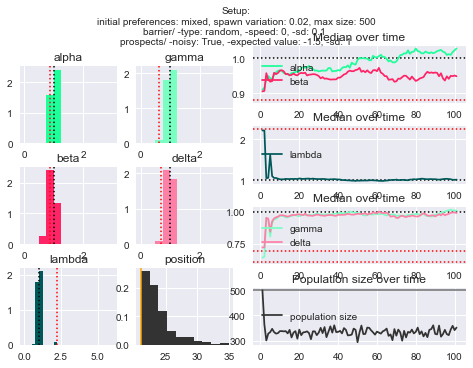

In [76]:
# final results
env1.population_grapher.graph_population_combined()